# Analyse MS/MS dataset using MS2DeepScore (and MS2Query)

The goal of this notebook is to show how `MS2DeepScore` can be used to analyse a MS/MS dataset.
We will further use results produced by `MS2Query` to better interpret the outcomes.

In [ ]:
# Necessary to install (if not present yet)
!pip install ms2deepscore  # This will automatically install matchms as well!

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.9/136.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.

# Import libraries

In [ ]:
import os
from matplotlib import pyplot as plt

from matchms import calculate_scores
from matchms.importing import load_from_mgf

from ms2deepscore import MS2DeepScore
from ms2deepscore.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify data (and model) locations
path_root = "./drive/MyDrive/summerschool2023_matchms"
file = os.path.join(path_root, "data_mzmine", "example_iimn_gnps.mgf")
spectra = list(load_from_mgf(file))

In [ ]:
# How many spectra did we get?
len(spectra)

6112

In [ ]:
spectra[0].metadata

{'feature_id': '8808',
 'pepmass': (150.5959, None),
 'scans': '8808',
 'charge': 2,
 'retention_time': 289.304,
 'ms_level': '2',
 'precursor_mz': 150.5959}

## Process spectra
We will apply:
- A few default filters to harmonize metadata
- Normalize peak intensities (to max=1.0)
- Remove all peaks outside 10.0 to 1000.0 Da m/z window
- Remove spectra with < 4 remaining peaks

The last two teps are potentially important for tools like `Spec2Vec` or `MS2DeepScore` which make predictions solely based on the MS2 peaks.

In [ ]:
from matchms import SpectrumProcessor

min_number_peaks = 4

# Define filter pipeline
processor = SpectrumProcessor("basic")
processor.add_matchms_filter("normalize_intensities")
processor.add_matchms_filter(("select_by_mz", {"mz_from": 10, "mz_to": 1000}))
processor.add_matchms_filter(("require_minimum_number_of_peaks", {"n_required": min_number_peaks}))

# Apply filter pipeline
spectra_cleaned = processor.process_spectrums(spectra)
len(spectra_cleaned)

Processing spectrums: 100%|██████████| 6112/6112 [00:18<00:00, 326.47it/s]


3802

In [ ]:
spectra_cleaned[0].metadata

{'feature_id': '8808',
 'pepmass': (150.5959, None),
 'scans': '8808',
 'charge': 2,
 'retention_time': 289.304,
 'ms_level': '2',
 'precursor_mz': 150.5959,
 'ionmode': 'n/a'}

## MS2DeepScore

`MS2DeepScore` is a deep learning approach to predict Tanimoto score between two MS/MS spectra (without having any chemical information about both compounds obviously...).

See also:
- [MS2DeepScore article](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-021-00558-4)
- [MS2DeepScore Python library (GitHub)](https://github.com/matchms/ms2deepscore)

### Load a pre-trained deep learning model
We will use a model which was trained on positive ionmode data from GNPS (roughly 25.000 compounds, data downloaded on 02/01/2023).
The model can be found on zenodeo: https://zenodo.org/record/8274763 (but will also be in the google drive folder!)

In [ ]:
# Load pretrained model
filename_model = "ms2deepscore_positive_10k_1000_1000_1000_500.hdf5"
model = load_model(os.path.join(path_root, "ms2deepscore_model", filename_model))
ms2ds = MS2DeepScore(model)

### Compute MS2DeepScore Tanimoto score predictions
The following step will compute Tanimoto score predictions for any possible pair of spectra in our dataset.

In [ ]:
# Calculate scores and get matchms.Scores object
scores = calculate_scores(spectra_cleaned, spectra_cleaned, ms2ds, is_symmetric=True)

Calculating vectors of reference spectrums: 100%|██████████| 3802/3802 [05:46<00:00, 10.98it/s]


In [ ]:
scores.scores.to_array()[:5, :5]

array([[1.        , 0.77392899, 0.77343831, 0.84322552, 0.89900177],
       [0.77392899, 1.        , 0.94214407, 0.79890381, 0.75886577],
       [0.77343831, 0.94214407, 1.        , 0.75514099, 0.8012301 ],
       [0.84322552, 0.79890381, 0.75514099, 1.        , 0.81057384],
       [0.89900177, 0.75886577, 0.8012301 , 0.81057384, 1.        ]])

### One example of what to do with those scores: Molecular Networking

In [ ]:
from matchms.networking import SimilarityNetwork

# Define settings
ms2ds_network = SimilarityNetwork(
    identifier_key = "scans",
    score_cutoff = 0.85,  # higher numbers produce more isolated sub-graphs
    max_links = 5,  # lower number makes sparser networks
    link_method = "mutual",  # mutual means: link is only added if in top list of both nodes
)

# Compute the graph (takes some time)
ms2ds_network.create_network(scores)

In [ ]:
# Export to graphml
ms2ds_network.export_to_graphml("ms2ds_graph.graphml")

## MS2DeepScore embeddings for mapping

Embeddings are abstract vectors, usually with the goal to represent data in an abstract vector space. MS2DeepScore aims to "compress" input spectra to such embeddings which finally is also used to compute similarities between two spectra.

However, embeddings can also be used for many other purposes. One of them is to start a further dimensionality reduction based on such embeddings, for instance with algorithms such as t-SNE, UMAP, or TMAP. Here we will use `UMAP` to compute 2D positions for each spectrum in our data based on MS2DeepScore embeddings. The goal of this is to identify groups or clusters of related spectra, as well as to get an impression of the general composition of our dataset.

### Umap
For more details on UMAP see [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/index.html).
Feel free to play with the key parameters (`n_neighbors` and `min_dist`) --> https://umap-learn.readthedocs.io/en/latest/parameters.html

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82808 sha256=9a19c1c8e848a6acc78077e200f60eb2fa637c06ee764bd55bd9e9d6b4ebe718
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55617 sha256=6e4258bb4c654cba9e3b576efdd98a77ac0300c65888043c776c1b119dad7396
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
ms2ds_vectors = ms2ds.calculate_vectors(spectra_cleaned)

Calculating vectors of reference spectrums: 100%|██████████| 3802/3802 [06:05<00:00, 10.41it/s]


In [ ]:
import umap  # if this doesn't work, try to use: import umap.umap_ as umap

reducer = umap.UMAP(random_state=42, n_neighbors=10, min_dist=0.25)  # feel free to play with the parameters!

In [ ]:
reducer.fit(ms2ds_vectors)

UMAP(min_dist=0.25, n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
embedding_umap = reducer.transform(ms2ds_vectors)
embedding_umap.shape

(3802, 2)

In [ ]:
# Get some labels and let's start with something simple:
masses = [s.get("precursor_mz") for s in spectra_cleaned]
masses = [s if s is not None else 0 for s in masses]

In [ ]:
import pandas as pd
scans = [s.get("scans") for s in spectra]
data_plot = pd.DataFrame({"x": embedding_umap[:, 0],
                          "y": embedding_umap[:, 1],
                          "scan": [s.get("scans") for s in spectra_cleaned],
                          "precursor-mz": masses,
                          })
data_plot.head()

,x,y,scan,precursor-mz
0,2.665076,-3.126076,8808,150.5959
1,3.447132,-3.587298,4094,151.0390
2,3.291631,-3.768991,2584,151.0391
3,2.945918,-3.178990,5788,151.0754
4,3.013630,-3.762539,5122,151.0754


In [ ]:
import plotly.express as px
import numpy as np

# Create scatter plot using Plotly Express
fig = px.scatter(data_plot,
    x="x",
    y="y",
    color="precursor-mz",
    color_continuous_scale="viridis",
    size_max=50,
    opacity=0.5,
    title='UMAP projection MS2DeepScore embeddings',
    hover_data={"x": False,
                "y": False,
                "scan": True,
                "precursor-mz": True},
    width=800,
    height=800,
)

# Display the figure
fig.show()

---
## MS2Query

Finally, let's use results obtained with **MS2Query** to help interpreting our data. MS2Query essentially uses a Random Forest model that aims to finds the chemically most similar compounds in a library based on scores such as MS2DeepScore and Spec2Vec, but also mass differences etc.


In [ ]:
file_ms2query = os.path.join(path_root, "results_ms2query", "ms2query_results_example.csv")
data_ms2query = pd.read_csv(file_ms2query)
data_ms2query.head()

,query_spectrum_nr,ms2query_model_prediction,precursor_mz_difference,precursor_mz_query_spectrum,precursor_mz_analog,inchikey,analog_compound_name,smiles,retention_time,feature_id,cf_kingdom,cf_superclass,cf_class,cf_subclass,cf_direct_parent,npc_class_results,npc_superclass_results,npc_pathway_results
0,1,0.4090,443.8251,150.5959,594.421,RZQNQMRSGMXXMH,"5-[5-(3,5-dihydroxydecanoyloxy)-3-hydroxydecan...",CCCCCC(O)CC(O)CC(=O)OC(CCCCC)CC(O)CC(=O)OC(CCC...,289.304,8808,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,Tricarboxylic acids and derivatives,Tricarboxylic acids and derivatives,Fatty acid estolides,Fatty esters,Fatty acids
1,2,0.6290,0.0000,151.0390,151.039,MRIXVKKOHPQOFK,4-Methoxysalicylic acid,COc1ccc(C(=O)O)c(O)c1,198.317,4094,Organic compounds,Benzenoids,Benzene and substituted derivatives,Benzoic acids and derivatives,P-methoxybenzoic acids and derivatives,Simple phenolic acids,Phenolic acids (C6-C1),Shikimates and Phenylpropanoids
2,3,0.6290,0.0001,151.0391,151.039,MRIXVKKOHPQOFK,4-Methoxysalicylic acid,COc1ccc(C(=O)O)c(O)c1,166.992,2584,Organic compounds,Benzenoids,Benzene and substituted derivatives,Benzoic acids and derivatives,P-methoxybenzoic acids and derivatives,Simple phenolic acids,Phenolic acids (C6-C1),Shikimates and Phenylpropanoids
3,4,0.6241,0.0004,151.0754,151.075,AUDBREYGQOXIFT,"(3,5-dimethoxyphenyl)methan-1-ol",COc1cc(CO)cc(OC)c1,227.732,5788,Organic compounds,Benzenoids,Benzene and substituted derivatives,Methoxybenzenes,Dimethoxybenzenes,NaN,NaN,Polyketides
4,5,0.6253,0.0004,151.0754,151.075,XHUBSJRBOQIZNI,Homovanillyl alcohol,COc1cc(CCO)ccc1O,215.224,5122,Organic compounds,Benzenoids,Phenols,Methoxyphenols,Methoxyphenols,Phenylethanoids,Phenylethanoids (C6-C2),Shikimates and Phenylpropanoids


In [ ]:
data_ms2query[data_ms2query.feature_id == 9065]

,query_spectrum_nr,ms2query_model_prediction,precursor_mz_difference,precursor_mz_query_spectrum,precursor_mz_analog,inchikey,analog_compound_name,smiles,retention_time,feature_id,cf_kingdom,cf_superclass,cf_class,cf_subclass,cf_direct_parent,npc_class_results,npc_superclass_results,npc_pathway_results
2032,2033,0.4887,165.0063,312.1597,477.166,MSXOSDJERSCOQW,"(2R)-2-phenyl-2-[[2-[[2-(2,3,5-trimethyl-7-oxo...",Cc1oc2cc3oc(=O)c(CC(=O)NCC(=O)N[C@@H](C(=O)O)c...,299.162,9065,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",Dipeptides,Simple coumarins,Coumarins,Shikimates and Phenylpropanoids


Text(0.5, 0, 'MS2Query score')

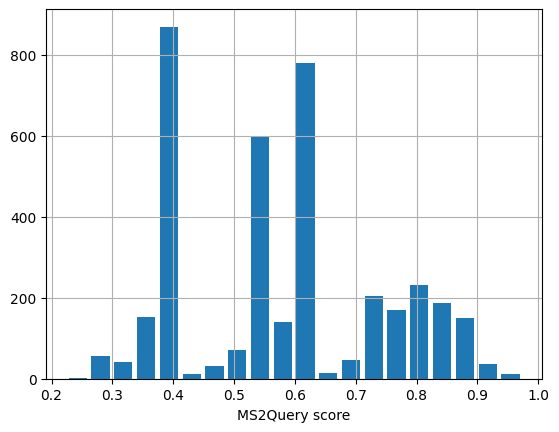

In [ ]:
data_ms2query.ms2query_model_prediction.hist(bins=20, rwidth=0.8)
plt.xlabel("MS2Query score")

In [ ]:
# this part differs from the live coding session to work with the different group datasets (hopefully)
import numpy as np

# get feature ids
feature_ids = np.array([s.get("feature_id") for s in spectra_cleaned])

# map to rows of the imported metadata
row_ids = []
for id in feature_ids:
    matching_row = np.where(data_ms2query.feature_id.values == id)[0]
    row_ids.append(matching_row)

row_ids = np.array(row_ids).reshape(-1)

In [ ]:
import pandas as pd

data_plot = pd.DataFrame({"x": embedding_umap[:, 0],
                          "y": embedding_umap[:, 1],
                          "feature_id": data_ms2query.feature_id.values[row_ids],
                          "superclass": data_ms2query.cf_superclass.values[row_ids],
                          "npc_pathway": data_ms2query.npc_pathway_results.values[row_ids],
                          "potential_analoque:": data_ms2query.analog_compound_name.values[row_ids],
                          "ms2query_tanimoto_prediction": data_ms2query.ms2query_model_prediction.values[row_ids],
                          })
data_plot.head()

,x,y,feature_id,superclass,npc_pathway,potential_analoque:,ms2query_tanimoto_prediction
0,2.665076,-3.126076,8808,Organic acids and derivatives,Fatty acids,"5-[5-(3,5-dihydroxydecanoyloxy)-3-hydroxydecan...",0.4090
1,3.447132,-3.587298,4094,Benzenoids,Shikimates and Phenylpropanoids,4-Methoxysalicylic acid,0.6290
2,3.291631,-3.768991,2584,Benzenoids,Shikimates and Phenylpropanoids,4-Methoxysalicylic acid,0.6290
3,2.945918,-3.178990,5788,Benzenoids,Polyketides,"(3,5-dimethoxyphenyl)methan-1-ol",0.6241
4,3.013630,-3.762539,5122,Benzenoids,Shikimates and Phenylpropanoids,Homovanillyl alcohol,0.6253


In [ ]:
import plotly.express as px
import numpy as np

# Create scatter plot using Plotly Express
fig = px.scatter(data_plot,
    x="x",
    y="y",
    color="superclass",
    size_max=20,
    opacity=0.5,
    title='UMAP projection MS2DeepScore embeddings',
    hover_data={"x": False,
                "y": False,
                "feature_id": True,
                "potential_analoque:": True,
                "ms2query_tanimoto_prediction": True},
    width=900,
    height=700,
)

# Display the figure
fig.show()

In [ ]:
# select high ms2query scores --> most reliable hits
mask = (data_ms2query.ms2query_model_prediction.values > 0.85) \
  & (data_ms2query.precursor_mz_difference < 1)

# Create scatter plot using Plotly Express
fig = px.scatter(data_plot[mask],
    x="x",
    y="y",
    color="superclass",
    size_max=50,
    opacity=0.5,
    title='UMAP projection MS2DeepScore embeddings',
    hover_data={"x": False,
                "y": False,
                "feature_id": True,
                "potential_analoque:": True,
                "ms2query_tanimoto_prediction": True},
    width=900,
    height=700,
)

# Display the figure
fig.show()